In [3]:
!pip install -q torchinfo thop captum h5py

In [1]:
import os
import math
import random
from collections import defaultdict, Counter
from typing import List, Optional

import h5py
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
import time
from thop import profile, clever_format
from captum.attr import Lime, IntegratedGradients
import torch.nn.functional as F


/home/ara/mim/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
PATH = r"C:\Users\oladipea\Documents\MIMIC-HAN\records"
SAMPLING_RATE = 500
PRE_PEAK_SAMPLES = 99
POST_PEAK_SAMPLES = 201
SEGMENT_LENGTH = PRE_PEAK_SAMPLES + POST_PEAK_SAMPLES  # 300
BATCH_SIZE = 16
DROP_LAST = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata


def pan_tompkins_detector(ecg_signal, fs):
    lowcut, highcut = 5.0, 15.0
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    diff_ecg = np.diff(filtered_ecg)
    squared_ecg = diff_ecg ** 2
    window_size = int(0.150 * fs)
    mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')
    peaks, _ = find_peaks(mwa_ecg, distance=int(0.6 * fs))
    return peaks


def multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=None):
    n_leads = len(detected_peaks)
    if min_leads is None:
        min_leads = int(np.ceil(n_leads / 2))

    # Collect all peaks with their lead information
    all_peaks = [(p, lead) for lead, peaks in enumerate(detected_peaks) for p in peaks]
    all_peaks.sort(key=lambda x: x[0])

    fused_peaks = []
    i = 0

    while i < len(all_peaks):
        # Start a new cluster
        cluster = [all_peaks[i]]
        i += 1

        # Add nearby peaks to the cluster
        while i < len(all_peaks) and all_peaks[i][0] - cluster[-1][0] <= fusion_window * fs:
            cluster.append(all_peaks[i])
            i += 1

        # Check if cluster has peaks from enough leads
        unique_leads = {lead for _, lead in cluster}
        if len(unique_leads) >= min_leads:
            # Use median position as the fused peak
            fused_peak = int(np.median([p for (p, _) in cluster]))
            fused_peaks.append(fused_peak)

    return np.array(sorted(fused_peaks))


def detect_r_peaks(ecg_signals, fs):
    detected_peaks = []
    for lead in ecg_signals:
        peaks = pan_tompkins_detector(lead, fs)
        detected_peaks.append(peaks)

    fused_r_peaks = multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=6)
    return fused_r_peaks


def extract_segments_around_peaks(signal, r_peaks, pre_samples, post_samples):
    segments = []

    for peak in r_peaks:
        start = max(0, peak - pre_samples)
        end = min(len(signal), peak + post_samples)

        # Only include segments with the correct length
        if end - start == pre_samples + post_samples:
            segment = signal[start:end]
            segments.append(segment)

    return segments

def extract_beats_multi_lead(ecg_signals, fs, pre_samples, post_samples, denoise_fn=None):
    # Convert to numpy array for consistent indexing
    ecg_signals = np.array(ecg_signals)

    # Apply denoising if provided
    if denoise_fn is not None:
        ecg_signals = np.array([denoise_fn(lead) for lead in ecg_signals])

    # Detect fused R-peaks across all leads
    r_peaks = detect_r_peaks(ecg_signals, fs)
    # print(f"Detected {len(r_peaks)} R-peaks after fusion")

    if len(r_peaks) == 0:
        return None

    # Extract segments from all leads
    all_lead_segments = []
    for lead_idx, lead_signal in enumerate(ecg_signals):
        segments = extract_segments_around_peaks(lead_signal, r_peaks, pre_samples, post_samples)
        all_lead_segments.append(segments)

    # Find the minimum number of valid segments across all leads
    min_segments = min(len(segments) for segments in all_lead_segments)
    # print(f"Extracted {min_segments} valid segments across all leads")

    if min_segments == 0:
        return None

    # Stack segments: (n_beats, segment_length, n_leads)
    beats_arr = np.stack([
        np.stack(segments[:min_segments], axis=0)
        for segments in all_lead_segments
    ], axis=-1)

    return beats_arr.astype(np.float32)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
from collections import Counter
from joblib import Parallel, delayed
import multiprocessing as mp

# -------------------------
metadata = pd.read_csv("metadata.csv")
codes = pd.read_csv("code.csv")

code_mappings = dict(zip(codes['Code'].astype(str), codes['Description']))

metadata = metadata[~metadata['AHA_Code'].str.contains(";")]
metadata['AHA_Code'] = metadata['AHA_Code'].str.split("+").str[0]
metadata['AHA_Code_Mapped'] = metadata['AHA_Code'].map(code_mappings)

unique_labels = sorted(metadata['AHA_Code_Mapped'].dropna().unique())
label2idx = {lbl: i for i, lbl in enumerate(unique_labels)}
num_classes = len(unique_labels)

print("num_classes:", num_classes, "labels:", unique_labels)

def process_row(row):
    ecg_data_path = os.path.join(PATH, row.ECG_ID + ".h5")
    if not os.path.exists(ecg_data_path):
        return None

    label = row.AHA_Code_Mapped
    if pd.isna(label) or label not in label2idx:
        return None

    try:
        with h5py.File(ecg_data_path, 'r') as f:
            ecg = np.array(f['ecg'])
    except Exception as e:
        return None

    beats = extract_beats_multi_lead(
        ecg,
        fs=SAMPLING_RATE,
        pre_samples=PRE_PEAK_SAMPLES,
        post_samples=POST_PEAK_SAMPLES,
        denoise_fn=denoise
    )

    if beats is None:
        return None

    return (np.array([denoise(lead) for lead in ecg]), beats.astype(np.float32), label2idx[label], row.AHA_Code_Mapped)

n_jobs = max(1, mp.cpu_count() - 1)

results = Parallel(
    n_jobs=n_jobs,
    backend="loky",
    verbose=10
)(
    delayed(process_row)(row)
    for row in metadata.itertuples(index=False)
)

data_list = [{'full_ecg_signal': r[0], 'beats': r[1], 'label_idx': r[2], 'label_description': r[3]} for r in results if r is not None]

print("Prepared records:", len(data_list))
# print("Beat counts distribution:", Counter([x[0].shape[0] for x in data_list]))

num_classes: 36 labels: ['AV block, complete (third-degree)', 'Anterior MI', 'Anteroseptal MI', 'Atrial fibrillation', 'Atrial flutter', 'Atrial premature complex(es)', 'Atrial premature complexes, nonconducted', 'Early repolarization', 'Incomplete right bundle-branch block', 'Inferior MI', 'Junctional premature complex(es)', 'Junctional tachycardia', 'Left anterior fascicular block', 'Left atrial enlargement', 'Left bundle-branch block', 'Left posterior fascicular block', 'Left ventricular hypertrophy', 'Left-axis deviation', 'Low voltage', 'Normal ECG', 'Prolonged PR interval', 'Prolonged QT interval', 'Right bundle-branch block', 'Right-axis deviation', 'ST deviation', 'ST deviation with T-wave change', 'Second-degree AV block, Mobitz type I (Wenckebach)', 'Second-degree AV block, Mobitz type II', 'Short PR interval', 'Sinus arrhythmia', 'Sinus bradycardia', 'Sinus tachycardia', 'T-wave abnormality', 'TU fusion', 'Ventricular preexcitation', 'Ventricular premature complex(es)']


[Parallel(n_jobs=31)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=31)]: Batch computation too fast (0.04660224914550781s.) Setting batch_size=2.
[Parallel(n_jobs=31)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=31)]: Done  23 tasks      | elapsed:    0.1s
[Parallel(n_jobs=31)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=31)]: Done  51 tasks      | elapsed:    0.2s
[Parallel(n_jobs=31)]: Done  70 tasks      | elapsed:    0.3s
[Parallel(n_jobs=31)]: Done 104 tasks      | elapsed:    0.3s
[Parallel(n_jobs=31)]: Done 138 tasks      | elapsed:    0.4s
[Parallel(n_jobs=31)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=31)]: Done 214 tasks      | elapsed:    0.6s
[Parallel(n_jobs=31)]: Done 256 tasks      | elapsed:    0.7s
[Parallel(n_jobs=31)]: Done 298 tasks      | elapsed:    0.8s
[Parallel(n_jobs=31)]: Done 344 tasks      | elapsed:    0.9s
[Parallel(n_jobs=31)]: Done 390 tasks      | elapsed:    0.9s
[Parallel(n_jobs=31)]

Prepared records: 22046


[Parallel(n_jobs=31)]: Done 22046 out of 22046 | elapsed:   48.0s finished


In [4]:
samples = np.load(r"atrial_fibrillation.npy", allow_pickle=True)

In [ ]:
# -------------------------
# Attention / helper layers
# -------------------------
class ChannelAttention(nn.Module):
    """
    Expects x shape = (batch, channels, seq_len)
    """
    def __init__(self, channels, ratio=8):
        super().__init__()
        mid = max(1, channels // ratio)
        self.mlp = nn.Sequential(
            nn.Linear(channels, mid, bias=True),
            nn.ReLU(),
            nn.Linear(mid, channels, bias=True)
        )

    def forward(self, x):
        # x: (B, C, L)
        avg_pool = torch.mean(x, dim=2)           # (B, C)
        max_pool, _ = torch.max(x, dim=2)         # (B, C)
        avg_out = self.mlp(avg_pool)              # (B, C)
        max_out = self.mlp(max_pool)              # (B, C)
        att = torch.sigmoid(avg_out + max_out)    # (B, C)
        att = att.unsqueeze(2)                    # (B, C, 1)
        return x * att                             # broadcast multiply -> (B, C, L)


class SegmentAttention(nn.Module):
    def __init__(self, input_dim, units):
        super().__init__()
        self.linear = nn.Linear(input_dim, units, bias=True)  # W and b equivalent
        # u vector for scoring
        self.u = nn.Parameter(torch.randn(units))

    def forward(self, inputs):
        # inputs: (B, T, D)
        v = torch.tanh(self.linear(inputs))           # (B, T, units)
        # score each time step
        vu = torch.matmul(v, self.u)                  # (B, T)
        alphas = F.softmax(vu, dim=1)                 # softmax over time dimension
        output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)  # (B, D)
        return output, alphas


class TimeDistributedSegmentAttention(nn.Module):
    def __init__(self, input_dim, units):
        super().__init__()
        self.segment_attention = SegmentAttention(input_dim, units)

    def forward(self, inputs):
        # inputs: (B, S, T, D)
        B, S, T, D = inputs.shape
        flat = inputs.view(B * S, T, D)                       # (B*S, T, D)
        outputs, alphas = self.segment_attention(flat)        # (B*S, D), (B*S, T)
        outputs = outputs.view(B, S, D)                       # (B, S, D)
        alphas = alphas.view(B, S, T)                         # (B, S, T)
        return outputs, alphas


class HANWithAttention(nn.Module):
    def __init__(
        self,
        num_classes,
        conv_channels=128,
        segment_hidden=256,
        sequence_hidden=512,
        fc_hidden=2048,
        dropout=0.4,
    ):
        super().__init__()

        # 1D conv over 12 leads
        self.conv1d = nn.Conv1d(12, conv_channels, kernel_size=25, padding=12)
        self.channel_attention = ChannelAttention(conv_channels, ratio=8)
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Beat-level LSTM
        self.lstm_segment = nn.LSTM(
            input_size=conv_channels,
            hidden_size=segment_hidden,
            batch_first=True
        )
        self.time_distributed_attention = TimeDistributedSegmentAttention(
            segment_hidden,
            segment_hidden
        )

        # Sequence-level LSTM
        self.lstm_sequence = nn.LSTM(
            input_size=segment_hidden,
            hidden_size=sequence_hidden,
            batch_first=True
        )
        self.final_attention = SegmentAttention(sequence_hidden, sequence_hidden)

        self.fc = nn.Linear(sequence_hidden, fc_hidden)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(fc_hidden, num_classes)

    def forward(self, x):
        logits, _, _ = self.forward_with_attention(x)
        return logits

    def forward_with_attention(self, x):
        B, S, T, C = x.shape
        x = x.view(B * S, T, C).permute(0, 2, 1)

        conv = self.conv1d(x)
        att  = self.channel_attention(conv)
        pooled = self.pool(att).permute(0, 2, 1)     # (B*S, T2, conv_channels)

        seg_out, _ = self.lstm_segment(pooled)       # (B*S, T2, segment_hidden)

        seg_out = seg_out.view(B, S, seg_out.shape[1], seg_out.shape[2])

        seg_feats, seg_alphas = self.time_distributed_attention(seg_out)  # (B,S,segment_hidden)

        seq_out, _ = self.lstm_sequence(seg_feats)                        # (B,S,sequence_hidden)
        final_vec, final_alphas = self.final_attention(seq_out)           # (B,sequence_hidden), (B,S)

        x = F.relu(self.fc(final_vec))
        x = self.dropout(x)
        logits = self.classifier(x)                                       # (B,C)
        return logits, final_alphas, seg_alphas

In [ ]:
class LightSEModule(nn.Module):
    def __init__(self,
        in_channels,
        reduction = 16,
    ):
        super(LightSEModule, self).__init__()
        self.pool = nn.AdaptiveAvgPool1d(1)

        self.s_conv = DSConv1d(
            in_channels, in_channels//reduction,
            kernel_size = 1,
        )
        self.act_fn = nn.ReLU()
        self.e_conv = DSConv1d(
            in_channels//reduction, in_channels,
            kernel_size = 1,
        )

    def forward(self,
        input,
    ):
        attention_scores = self.pool(input)

        attention_scores = self.s_conv(attention_scores)
        attention_scores = self.act_fn(attention_scores)
        attention_scores = self.e_conv(attention_scores)

        return input*torch.sigmoid(attention_scores)

class DSConv1d(nn.Module):
    def __init__(self,
        in_channels, out_channels,
        kernel_size, padding = 0, stride = 1,
    ):
        super(DSConv1d, self).__init__()
        self.dw_conv = nn.Conv1d(
            in_channels, in_channels,
            kernel_size = kernel_size, padding = padding, stride = stride,
            groups = in_channels,
            bias = False,
        )
        self.pw_conv = nn.Conv1d(
            in_channels, out_channels,
            kernel_size = 1,
            bias = False,
        )

    def forward(self,
        input,
    ):
        output = self.dw_conv(input)
        output = self.pw_conv(output)

        return output

class LightSEResBlock(nn.Module):
    def __init__(self,
        in_channels,
        downsample = False,
    ):
        super(LightSEResBlock, self).__init__()
        if downsample:
            self.out_channels = in_channels*2
            self.conv_1 = DSConv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 2,
            )
            self.identity = nn.Sequential(
                DSConv1d(
                    in_channels, self.out_channels,
                    kernel_size = 1, padding = 0, stride = 2,
                ),
                nn.BatchNorm1d(self.out_channels),
            )
        else:
            self.out_channels = in_channels
            self.conv_1 = DSConv1d(
                in_channels, self.out_channels,
                kernel_size = 7, padding = 3, stride = 1,
            )
            self.identity = nn.Identity()
        self.conv_2 = DSConv1d(
            self.out_channels, self.out_channels,
            kernel_size = 7, padding = 3, stride = 1,
        )

        self.convs = nn.Sequential(
            self.conv_1,
            nn.BatchNorm1d(self.out_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            self.conv_2,
            nn.BatchNorm1d(self.out_channels),
            LightSEModule(self.out_channels),
        )
        self.act_fn = nn.ReLU()

    def forward(self,
        input,
    ):
        output = self.convs(input) + self.identity(input)
        output = self.act_fn(output)

        return output

class LightSEResNet18(nn.Module):
    def __init__(self,
        base_channels = 64,
    ):
        super(LightSEResNet18, self).__init__()
        self.bblock = LightSEResBlock
        self.stem = nn.Sequential(
            nn.Conv1d(
                1, base_channels,
                kernel_size = 15, padding = 7, stride = 2,
            ),
            nn.BatchNorm1d(base_channels),
            nn.ReLU(),
            nn.MaxPool1d(
                kernel_size = 3, padding = 1, stride = 2,
            ),
        )
        self.stage_0 = nn.Sequential(
            self.bblock(base_channels),
            self.bblock(base_channels),
        )

        self.stage_1 = nn.Sequential(
            self.bblock(base_channels*1, downsample = True),
            self.bblock(base_channels*2),
        )
        self.stage_2 = nn.Sequential(
            self.bblock(base_channels*2, downsample = True),
            self.bblock(base_channels*4),
        )
        self.stage_3 = nn.Sequential(
            self.bblock(base_channels*4, downsample = True),
            self.bblock(base_channels*8),
        )

        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self,
        input,
    ):
        output = self.stem(input)
        output = self.stage_0(output)

        output = self.stage_1(output)
        output = self.stage_2(output)
        output = self.stage_3(output)

        output = self.pool(output)

        return output


class LightX3ECG(nn.Module):
    def __init__(self,
        base_channels = 64,
        num_classes = 11,
    ):
        super(LightX3ECG, self).__init__()
        self.backbone_0 = LightSEResNet18(base_channels)
        self.backbone_1 = LightSEResNet18(base_channels)
        self.backbone_2 = LightSEResNet18(base_channels)
        self.lw_attention = nn.Sequential(
            nn.Linear(
                base_channels*24, base_channels*8,
            ),
            nn.BatchNorm1d(base_channels*8),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(
                base_channels*8, 3,
            ),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(
                base_channels*8, num_classes,
            ),
        )

    def forward(self,
        input,
        return_attention_scores = False,
    ):
        features_0 = self.backbone_0(input[:, 0, :].unsqueeze(1)).squeeze(2)
        features_1 = self.backbone_1(input[:, 1, :].unsqueeze(1)).squeeze(2)
        features_2 = self.backbone_2(input[:, 2, :].unsqueeze(1)).squeeze(2)
        attention_scores = torch.sigmoid(
            self.lw_attention(
                torch.cat(
                [
                    features_0,
                    features_1,
                    features_2,
                ],
                dim = 1,
                )
            )
        )
        merged_features = torch.sum(
            torch.stack(
            [
                features_0,
                features_1,
                features_2,
            ],
            dim = 1,
            )*attention_scores.unsqueeze(-1),
            dim = 1,
        )

        output = self.classifier(merged_features)

        if not return_attention_scores:
            return output
        else:
            return output, attention_scores

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------
# Channel Attention (CBAM)
# -------------------------
class ChannelAttention(nn.Module):
    def __init__(self, channels, ratio=8):
        super().__init__()
        hidden = max(1, channels // ratio)
        # Shared MLP
        self.mlp = nn.Sequential(
            nn.Linear(channels, hidden, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=True)
        )

    def forward(self, x):
        # x: (B, C, L)
        b, c, l = x.shape

        # Global average pooling and max pooling across temporal dimension -> (B, C)
        avg_pool = F.adaptive_avg_pool1d(x, 1).view(b, c)   # (B, C)
        max_pool = F.adaptive_max_pool1d(x, 1).view(b, c)   # (B, C)

        # Shared MLP applied to both
        avg_out = self.mlp(avg_pool)  # (B, C)
        max_out = self.mlp(max_pool)  # (B, C)

        # Combine and sigmoid
        out = torch.sigmoid(avg_out + max_out).unsqueeze(-1)  # (B, C, 1)

        # Scale input
        return x * out  # broadcasting over length

# -------------------------
# Spatial Attention (CBAM)
# -------------------------
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv1d(in_channels=2, out_channels=1,
                              kernel_size=kernel_size, padding=padding, bias=False)
        # we will apply sigmoid after conv

    def forward(self, x):
        # x: (B, C, L)
        # channel-wise avg and max -> (B, 1, L)
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)

        cat = torch.cat([avg_pool, max_pool], dim=1)  # (B, 2, L)
        attn = torch.sigmoid(self.conv(cat))  # (B, 1, L)
        return x * attn  # broadcast over channels

# -------------------------
# Transformer Encoder Block
# -------------------------
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.2):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                         dropout=dropout_rate, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(inplace=True),
            nn.Linear(dff, d_model)
        )
        self.dropout2 = nn.Dropout(dropout_rate)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        # x: (B, L, D)
        attn_out, _ = self.mha(x, x, x,
                              attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)
        attn_out = self.dropout1(attn_out)
        x = self.norm1(x + attn_out)

        ffn_out = self.ffn(x)
        ffn_out = self.dropout2(ffn_out)
        x = self.norm2(x + ffn_out)
        return x  # (B, L, D)

# -------------------------
# Positional Encoding (sinusoidal)
# -------------------------
def sinusoidal_positional_encoding(seq_len, d_model, device=None, dtype=None):
    if device is None:
        device = torch.device('cpu')
    pe = torch.zeros(seq_len, d_model, device=device, dtype=dtype)
    position = torch.arange(0, seq_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device, dtype=torch.float)
                         * -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # (1, seq_len, d_model)

# -------------------------
# Full Model
# -------------------------
class ECGModel(nn.Module):
    def __init__(self, sequence_length=5000, num_channels=12,
                 d_model=128, num_heads=4, dff=128, dropout_rate=0.2,
                 num_classes=11, apply_softmax=False):
        super().__init__()
        self.apply_softmax = apply_softmax

        self.conv1 = nn.Conv1d(in_channels=num_channels, out_channels=32, kernel_size=21, padding=(21-1)//2)
        # self.bn1 = nn.BatchNorm1d(32)
        self.bn1 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.ca1 = ChannelAttention(32, ratio=8)
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1) 

        self.conv2 = nn.Conv1d(32, 32, kernel_size=23, padding=(23-1)//2)
        # self.bn2 = nn.BatchNorm1d(32)
        self.bn2 = nn.GroupNorm(num_groups=8, num_channels=32)
        self.ca2 = ChannelAttention(32, ratio=8)
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=25, padding=(25-1)//2)
        # self.bn3 = nn.BatchNorm1d(64)
        self.bn3 = nn.GroupNorm(num_groups=8, num_channels=64)
        self.ca3 = ChannelAttention(64, ratio=8)
        self.pool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.conv4 = nn.Conv1d(64, 128, kernel_size=27, padding=(27-1)//2)
        # self.bn4 = nn.BatchNorm1d(128)
        self.bn4 = nn.GroupNorm(num_groups=8, num_channels=128)
        self.ca4 = ChannelAttention(128, ratio=8)

        if 128 != d_model:
            self.project_to_d_model = nn.Conv1d(128, d_model, kernel_size=1)
        else:
            self.project_to_d_model = None

        # Transformer encoder
        self.transformer_block = TransformerEncoderBlock(d_model=d_model, num_heads=num_heads,
                                                         dff=dff, dropout_rate=dropout_rate)

        self.flatten = nn.Flatten()
        self.fc1 = None 
        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(128, num_classes)
        self._init_weights()
        self._configured = False
        self.d_model = d_model

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def _init_fc_head(self, sample_batch, device):
        self.eval()
        with torch.no_grad():
            x = sample_batch.to(device)
            features = self._forward_features(x)  # returns (B, L, D) after transformer
            flat = features.reshape(features.size(0), -1)
            in_features = flat.size(1)
            self.fc1 = nn.Linear(in_features, 128).to(device)
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.zeros_(self.fc1.bias)
            self._configured = True


    def _forward_features(self, x):
        x = x.permute(0, 2, 1)  # -> (B, C, L)
        # Conv → BN → ReLU → CA → Pool
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.ca1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x, inplace=True)
        x = self.ca2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x, inplace=True)
        x = self.ca3(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x, inplace=True)
        x = self.ca4(x)
        # x: (B, channels, L_final)

        if self.project_to_d_model is not None:
            x = self.project_to_d_model(x)  # (B, d_model, L_final)

        # Transpose for transformer: (B, L, D)
        x = x.permute(0, 2, 1)

        seq_len = x.size(1)
        pe = sinusoidal_positional_encoding(seq_len, self.d_model, device=x.device, dtype=x.dtype)
        x = x + pe  # (B, L, D)

        # Transformer encoder block
        x = self.transformer_block(x)  # (B, L, D)
        return x

    def forward(self, x):
        device = x.device

        # lazy init fc1 if necessary (to know flatten size)
        if not self._configured:
            self._init_fc_head(x, device)

        features = self._forward_features(x)  # (B, L, D)
        pooled = features.mean(dim=1)         # (B, D)
        pooled = self.dropout(pooled)
        logits = self.fc_out(pooled)

        if self.apply_softmax:
            return F.softmax(logits, dim=-1)
        return logits

In [12]:
han = torch.load("han.pth", map_location="cpu",  weights_only=False)
lightx3ecg_model = torch.load("lightx3ecg.pth",  map_location="cpu",  weights_only=False)
catnet_model = torch.load("catnet.pth",  map_location="cpu",  weights_only=False)

In [13]:
device = torch.device('cpu')

In [14]:
han_model = HANWithAttention(num_classes=11,
                            conv_channels=128,
                            segment_hidden=128,
                            sequence_hidden=512,
                            fc_hidden=512,
                            dropout=0.3)
han_model.load_state_dict(han)

<All keys matched successfully>

## ----- LIME -----

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Lime
import torch.nn.functional as F

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def run_lime(model, x, y_true_description, y_true, baseline='zero', full=None, r_peaks=None, pre_samples=99, post_samples=201):
    set_seed(10)
    is_4d = len(x.shape) == 4

    # -----------------------------
    # Feature mask
    # -----------------------------
    feature_mask = torch.zeros_like(x, dtype=torch.long)
    feature_count = 0

    if is_4d:
        B, n_beats, n_time, n_channels = x.shape
        chunks_per_beat = 6
        chunk_len = n_time // chunks_per_beat
        for b in range(n_beats):
            for i in range(chunks_per_beat):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, b, t_start:t_end, :] = feature_count
                feature_count += 1
    else:
        B, dim1, dim2 = x.shape
        if dim1 == 12:
            n_channels, n_time = dim1, dim2
            chunk_len = 50
            for i in range(n_time // chunk_len):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, :, t_start:t_end] = feature_count
                feature_count += 1
        else:
            n_time, n_channels = dim1, dim2
            chunk_len = 50
            for i in range(n_time // chunk_len):
                t_start = i * chunk_len
                t_end = min((i + 1) * chunk_len, n_time)
                feature_mask[:, t_start:t_end, :] = feature_count
                feature_count += 1

    print(f"Total LIME features generated: {feature_count}")

    def model_forward_probs(input_tensor):
        return model(input_tensor)

    with torch.no_grad():
        y_pred = torch.argmax(model_forward_probs(x), dim=1).item()


    if baseline == 'zero':
        baselines = torch.zeros_like(x)
    elif baseline == 'noise':
        baselines = torch.randn_like(x) * 0.01
    else:
        raise ValueError(f"Unknown baseline: {baseline}")

    # -----------------------------
    # Run LIME
    # -----------------------------
    lime = Lime(model_forward_probs)
    print("Computing LIME attributions...")
    attributions = lime.attribute(
        inputs=x,
        target=y_pred,
        feature_mask=feature_mask,
        baselines=baselines,
        n_samples=5000,
        perturbations_per_eval=49,
        show_progress=True
    )

    # -----------------------------
    # Plotting
    # -----------------------------
    lead_idx = 1  # Lead II

    if is_4d and full is not None and r_peaks is not None:
        # 4D beat input → map to full ECG
        full_len = full.shape[2]  # 5000
        attr_full = np.zeros(full_len)
        ecg_full = full[0, lead_idx, :].cpu().detach().numpy()

        beat_len = x.shape[2]
        for i, peak in enumerate(r_peaks):
            start = max(0, peak - pre_samples)
            end = min(full_len, peak + post_samples)
            beat_attr = attributions[0, i, :, lead_idx].cpu().detach().numpy()

            # Interpolate to match the window size
            beat_attr_interp = np.interp(np.arange(end - start),
                                        np.linspace(0, end - start, len(beat_attr)),
                                        beat_attr)
            attr_full[start:end] = beat_attr_interp


        attr_norm = attr_full / np.max(np.abs(attr_full)) if np.max(np.abs(attr_full)) > 0 else attr_full
        ecg_to_plot = ecg_full
        time_steps = np.arange(full_len)

    else:
        # full ECG input (3D)
        if x.shape[1] == 12:  # channels-first
            ecg_full = x[0, lead_idx, :].cpu().detach().numpy()
            attr_norm = attributions[0, lead_idx, :].cpu().detach().numpy()
        else:  # channels-last
            ecg_full = x[0, :, lead_idx].cpu().detach().numpy()
            attr_norm = attributions[0, :, lead_idx].cpu().detach().numpy()
        attr_norm = attr_norm / np.max(np.abs(attr_norm)) if np.max(np.abs(attr_norm)) > 0 else attr_norm
        time_steps = np.arange(len(ecg_full))

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(time_steps, ecg_full, 'k-', alpha=0.6, label='ECG Signal')
    im = ax.pcolormesh([time_steps, time_steps],
                       [np.min(ecg_full), np.max(ecg_full)],
                       [attr_norm, attr_norm],
                       cmap='seismic',
                       alpha=0.4,
                       vmin=-1, vmax=1)
    # ax.set_title(f"LIME Attribution (Lead {lead_idx}, Class {y_true})\nFeatures: {feature_count} | Norm Scale: 1.0", fontsize=14)
    plt.colorbar(im, label="Importance (Normalized)")
    plt.xlabel("Time Step (Original ECG)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()


    print(f"Attribution Range: {attr_norm.min()} to {attr_norm.max()}")
    print(f"Mean Abs Attribution: {np.mean(np.abs(attr_norm))}")
    print(f"Actual label {y_true} - {y_true_description}. Predicted {y_pred}")
    
    return attr_norm



In [ ]:
# {'A': 0,
#  'C': 1,
#  'D': 2,
#  'E': 3,
#  'F': 4,
#  'H': 5,
#  'I': 6,
#  'J': 7,
#  'K': 8,
#  'L': 9,
#  'M': 10})

torch.Size([1, 12, 5000])
torch.Size([1, 5000, 12])
Total LIME features generated: 100
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:06<00:00,  1.55it/s]
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families we

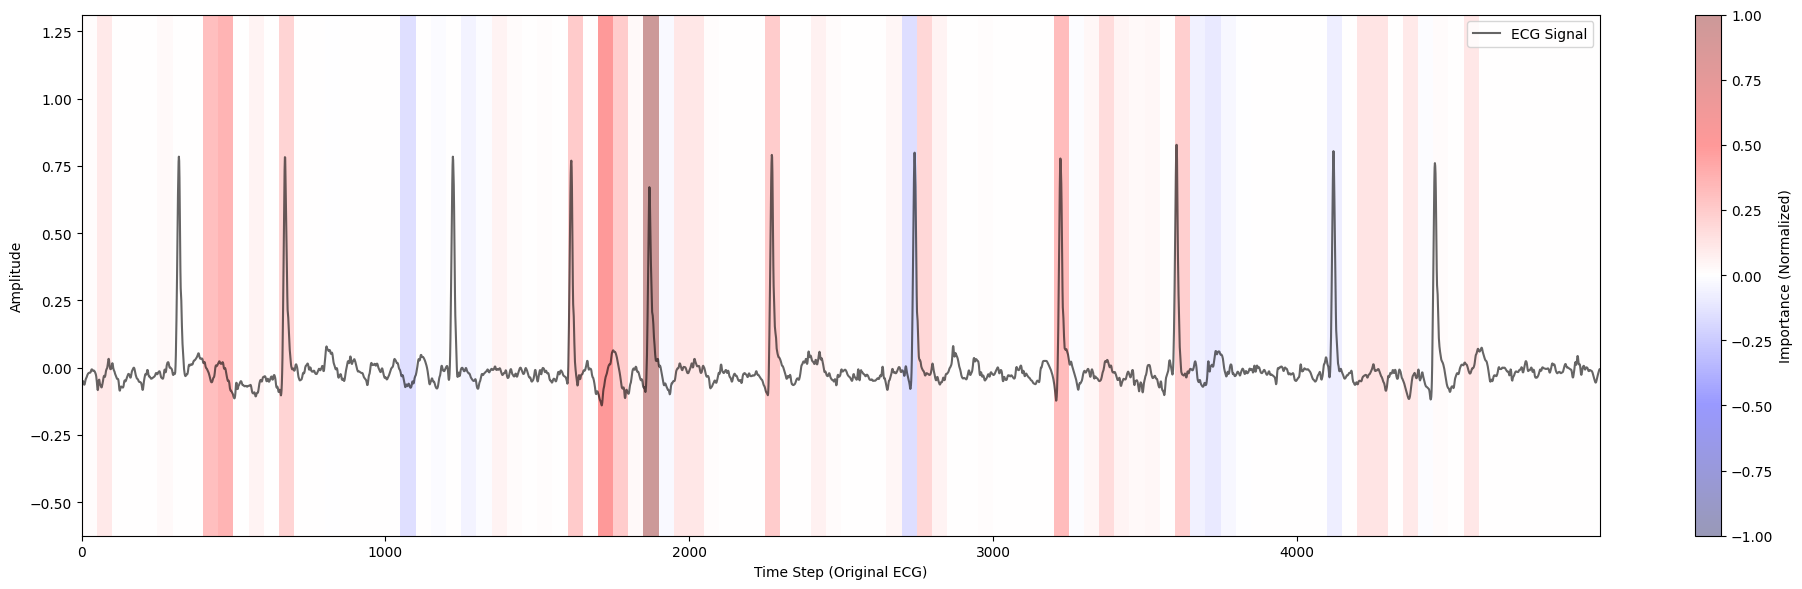

Attribution Range: -0.16332103312015533 to 1.0
Mean Abs Attribution: 0.06215915456414223
Actual label 3 - Atrial fibrillation. Predicted 3


In [ ]:
# 1. CATNET
catnet_model.eval()
catnet_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device) 
x = x[:, :5000]    
x = x.unsqueeze(0) 
print(x.shape)      
x = x.transpose(1, 2)   
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

catnet_lime_attr = run_lime(catnet_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 12, 5000])
Total LIME features generated: 100
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [02:52<00:00,  1.67s/it]
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families we

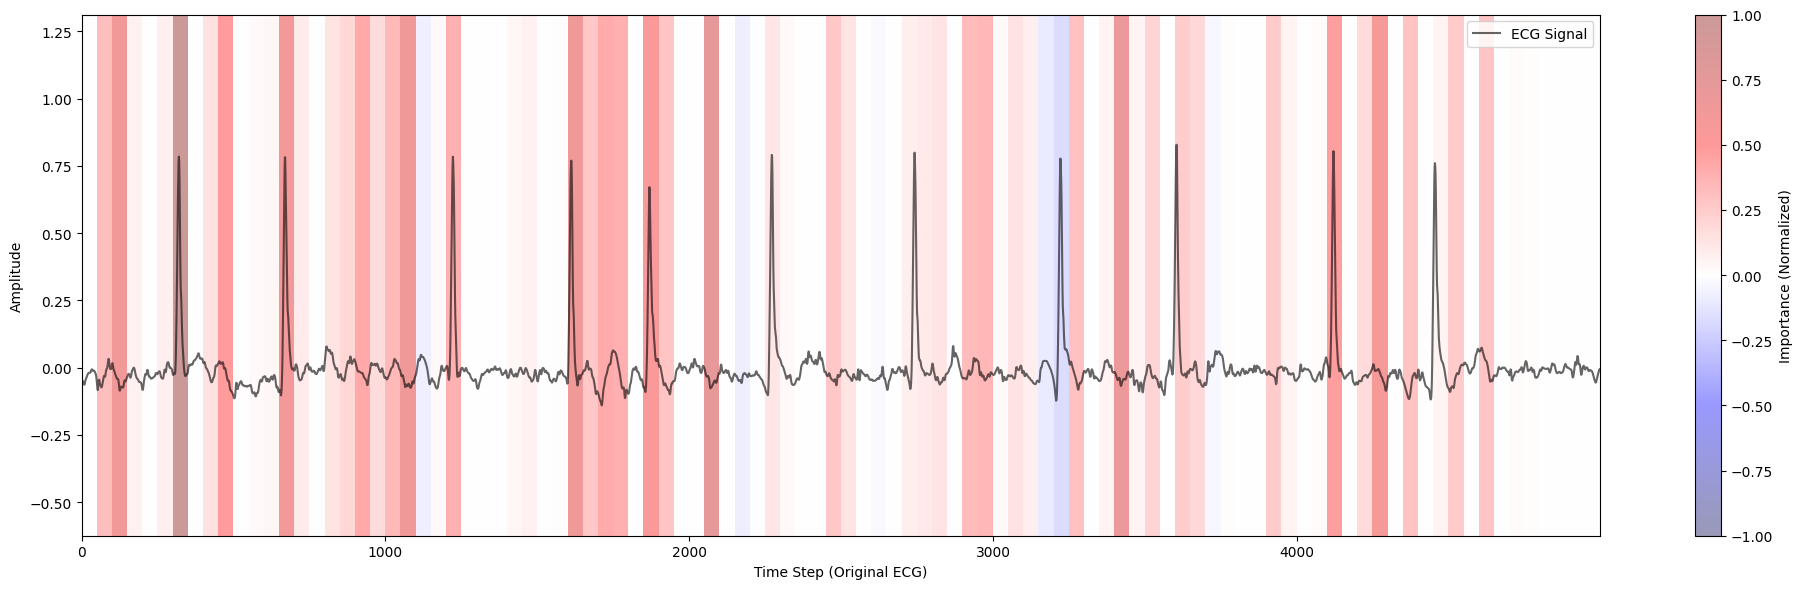

Attribution Range: -0.16647863388061523 to 1.0
Mean Abs Attribution: 0.15725015103816986
Actual label 3 - Atrial fibrillation. Predicted 3


In [ ]:
# 2. LIGHTX3ECG
lightx3ecg_model.eval()
lightx3ecg_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device) 
x = x[:, :5000]    
x = x.unsqueeze(0)  
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

lightx3cg_lime_attr = run_lime(lightx3ecg_model, x, y_true_description, y_true, 'zero')

In [ ]:
def pan_tompkins_detector(ecg_signal, fs):
    lowcut, highcut = 5.0, 15.0
    nyquist = 0.5 * fs
    low, high = lowcut / nyquist, highcut / nyquist
    b, a = butter(1, [low, high], btype='band')
    filtered_ecg = filtfilt(b, a, ecg_signal)
    diff_ecg = np.diff(filtered_ecg)
    squared_ecg = diff_ecg ** 2
    window_size = int(0.150 * fs)
    mwa_ecg = np.convolve(squared_ecg, np.ones(window_size) / window_size, mode='same')
    peaks, _ = find_peaks(mwa_ecg, distance=int(0.6 * fs))
    return peaks


def multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=None):
    n_leads = len(detected_peaks)
    if min_leads is None:
        min_leads = int(np.ceil(n_leads / 2))

    all_peaks = [(p, lead) for lead, peaks in enumerate(detected_peaks) for p in peaks]
    all_peaks.sort(key=lambda x: x[0])

    fused_peaks = []
    i = 0

    while i < len(all_peaks):
        cluster = [all_peaks[i]]
        i += 1

        while i < len(all_peaks) and all_peaks[i][0] - cluster[-1][0] <= fusion_window * fs:
            cluster.append(all_peaks[i])
            i += 1

        unique_leads = {lead for _, lead in cluster}
        if len(unique_leads) >= min_leads:
            fused_peak = int(np.median([p for (p, _) in cluster]))
            fused_peaks.append(fused_peak)

    return np.array(sorted(fused_peaks))


def detect_r_peaks(ecg_signals, fs):
    detected_peaks = []
    for lead in ecg_signals:
        peaks = pan_tompkins_detector(lead, fs)
        detected_peaks.append(peaks)

    fused_r_peaks = multi_lead_fusion(detected_peaks, fs, fusion_window=0.1, min_leads=6)
    return fused_r_peaks


def extract_segments_around_peaks(signal, r_peaks, pre_samples, post_samples):
    segments = []

    for peak in r_peaks:
        start = max(0, peak - pre_samples)
        end = min(len(signal), peak + post_samples)

        if end - start == pre_samples + post_samples:
            segment = signal[start:end]
            segments.append(segment)

    return segments


def extract_beats_multi_lead(ecg_signals, fs, pre_samples, post_samples, denoise_fn=None):
    # Convert to numpy array for consistent indexing
    ecg_signals = np.array(ecg_signals)

    # Apply denoising if provided
    if denoise_fn is not None:
        ecg_signals = np.array([denoise_fn(lead) for lead in ecg_signals])

    # Detect fused R-peaks across all leads
    r_peaks = detect_r_peaks(ecg_signals, fs)
    # print(f"Detected {len(r_peaks)} R-peaks after fusion")

    if len(r_peaks) == 0:
        return None

    # Extract segments from all leads
    all_lead_segments = []
    for lead_idx, lead_signal in enumerate(ecg_signals):
        segments = extract_segments_around_peaks(lead_signal, r_peaks, pre_samples, post_samples)
        all_lead_segments.append(segments)

    # Find the minimum number of valid segments across all leads
    min_segments = min(len(segments) for segments in all_lead_segments)
    # print(f"Extracted {min_segments} valid segments across all leads")

    if min_segments == 0:
        return None

    # Stack segments: (n_beats, segment_length, n_leads)
    beats_arr = np.stack([
        np.stack(segments[:min_segments], axis=0)
        for segments in all_lead_segments
    ], axis=-1)

    return beats_arr.astype(np.float32)

torch.Size([1, 17, 300, 12])
Total LIME features generated: 102
Computing LIME attributions...


Lime attribution: 100%|██████████| 103/103 [01:00<00:00,  1.72it/s]
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families we

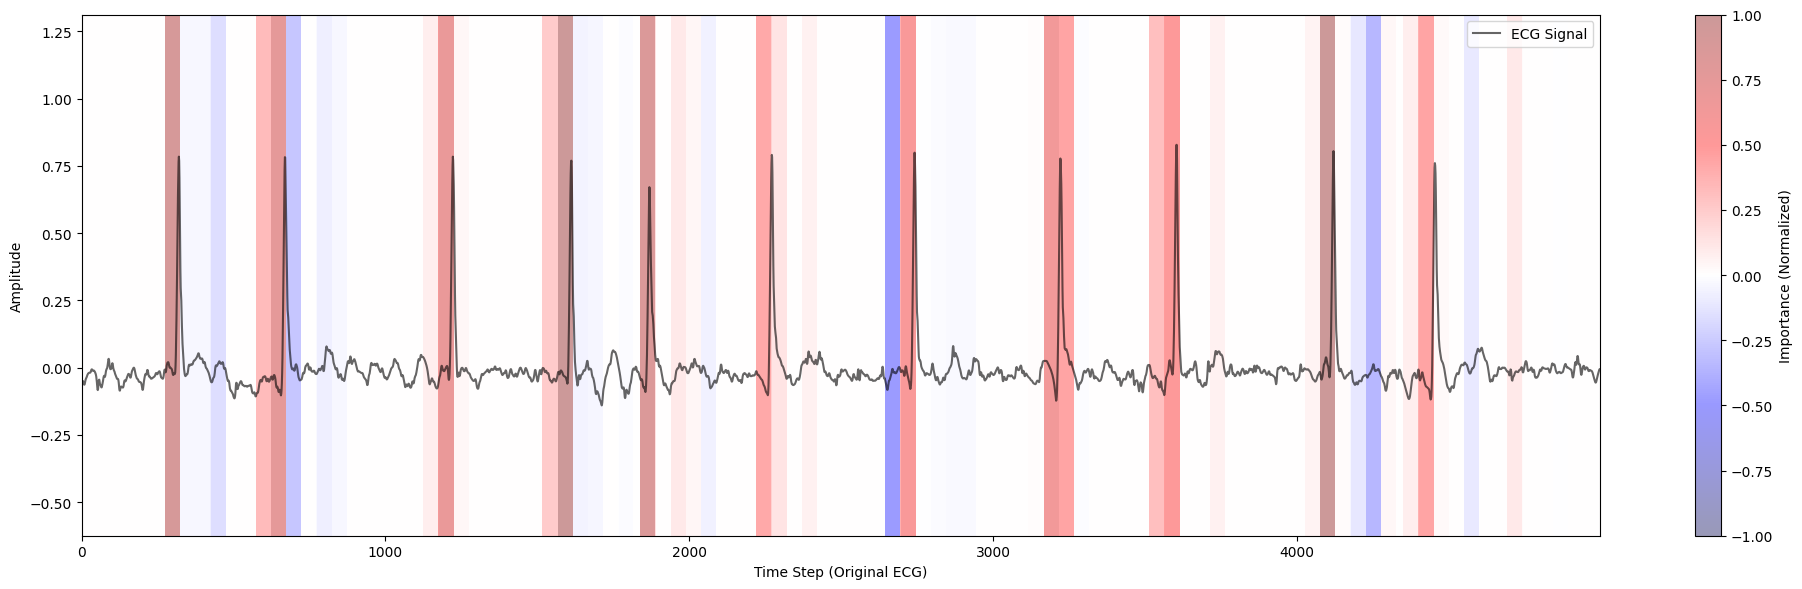

Attribution Range: -0.4866823020062917 to 1.0
Mean Abs Attribution: 0.11902002183239585
Actual label 3 - Atrial fibrillation. Predicted 3


In [73]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
han_lime_attr = run_lime(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import torch.nn.functional as F
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def run_ig(model, x, y_true_description, y_true, baseline='zero', full=None, r_peaks=None, pre_samples=99, post_samples=201):
    set_seed(10)
    is_4d = len(x.shape) == 4
    if is_4d:
        model.train()
    else:
        model.eval()
    device = x.device

    # -----------------------------
    # Model wrapper
    # -----------------------------
    def model_forward(input_tensor):
        return model(input_tensor)

    # Predict class
    with torch.no_grad():
        y_pred = torch.argmax(model_forward(x), dim=1).item()

    # -----------------------------
    # Baseline
    # -----------------------------
    if baseline == 'zero':
        baselines = torch.zeros_like(x)
    elif baseline == 'noise':
        baselines = torch.randn_like(x) * 0.01
    else:
        raise ValueError(f"Unknown baseline: {baseline}")

    # -----------------------------
    # Compute Integrated Gradients
    # -----------------------------
    ig = IntegratedGradients(model_forward)
    print("Computing Integrated Gradients attributions...")
    attributions, _ = ig.attribute(
        inputs=x,
        baselines=baselines,
        target=y_pred,
        return_convergence_delta=True
    )

    # -----------------------------
    # Plotting
    # -----------------------------
    lead_idx = 1  # Lead II

    if is_4d and full is not None and r_peaks is not None:
        # 4D beats → map back to full ECG
        full_len = full.shape[2]
        attr_full = np.zeros(full_len)
        ecg_full = full[0, lead_idx, :].cpu().detach().numpy()

        beat_len = x.shape[2]
        for i, peak in enumerate(r_peaks):
            start = max(0, peak - pre_samples)
            end = min(full_len, peak + post_samples)
            beat_attr = attributions[0, i, :, lead_idx].cpu().detach().numpy()

            # Interpolate to match the window
            beat_attr_interp = np.interp(np.arange(end - start),
                                        np.linspace(0, end - start, len(beat_attr)),
                                        beat_attr)
            attr_full[start:end] = beat_attr_interp

        attr_norm = attr_full / np.max(np.abs(attr_full)) if np.max(np.abs(attr_full)) > 0 else attr_full
        time_steps = np.arange(full_len)

    else:
        # Full ECG input (3D)
        if x.shape[1] == 12:  # channels-first
            ecg_full = x[0, lead_idx, :].cpu().detach().numpy()
            attr_norm = attributions[0, lead_idx, :].cpu().detach().numpy()
        else:  # channels-last
            ecg_full = x[0, :, lead_idx].cpu().detach().numpy()
            attr_norm = attributions[0, :, lead_idx].cpu().detach().numpy()
        attr_norm = attr_norm / np.max(np.abs(attr_norm)) if np.max(np.abs(attr_norm)) > 0 else attr_norm
        time_steps = np.arange(len(ecg_full))

    # -----------------------------
    # Plot
    # -----------------------------
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(time_steps, ecg_full, 'k-', alpha=0.6, label='ECG Signal')
    im = ax.pcolormesh([time_steps, time_steps],
                       [np.min(ecg_full), np.max(ecg_full)],
                       [attr_norm, attr_norm],
                       cmap='seismic',
                       alpha=0.4,
                       vmin=-1, vmax=1)
    ax.set_title(f"Integrated Gradients (Lead {lead_idx}, Class {y_true})", fontsize=14)
    plt.colorbar(im, label="Importance (Normalized)")
    plt.xlabel("Time Step (Original ECG)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Debugging stats
    # -----------------------------
    print(f"Attribution Range: {attr_norm.min()} to {attr_norm.max()}")
    print(f"Mean Abs Attribution: {np.mean(np.abs(attr_norm))}")
    print(f"Actual label {y_true} - {y_true_description}. Predicted {y_pred}")


### Integrated gradients

torch.Size([1, 12, 5000])
torch.Size([1, 5000, 12])
Computing Integrated Gradients attributions...


findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found bec

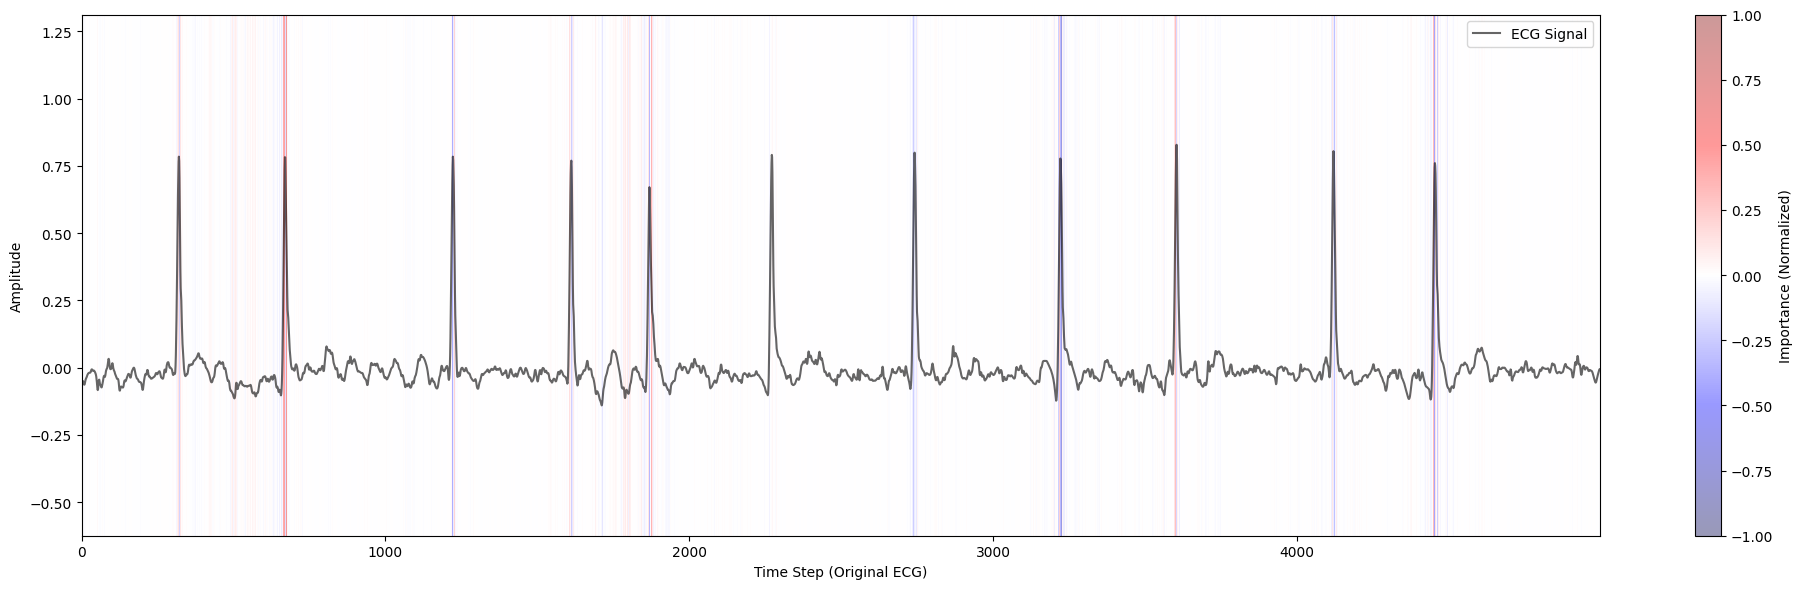

Attribution Range: -0.7680901288986206 to 1.0
Mean Abs Attribution: 0.013503222726285458
Actual label 3 - Atrial fibrillation. Predicted 3


In [38]:
# 1. CATNET
catnet_model.eval()
catnet_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)       # (1, 12, 5000)
x = x.transpose(1, 2)    # (1, Channels, 5000)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

run_ig(catnet_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 12, 5000])
Computing Integrated Gradients attributions...


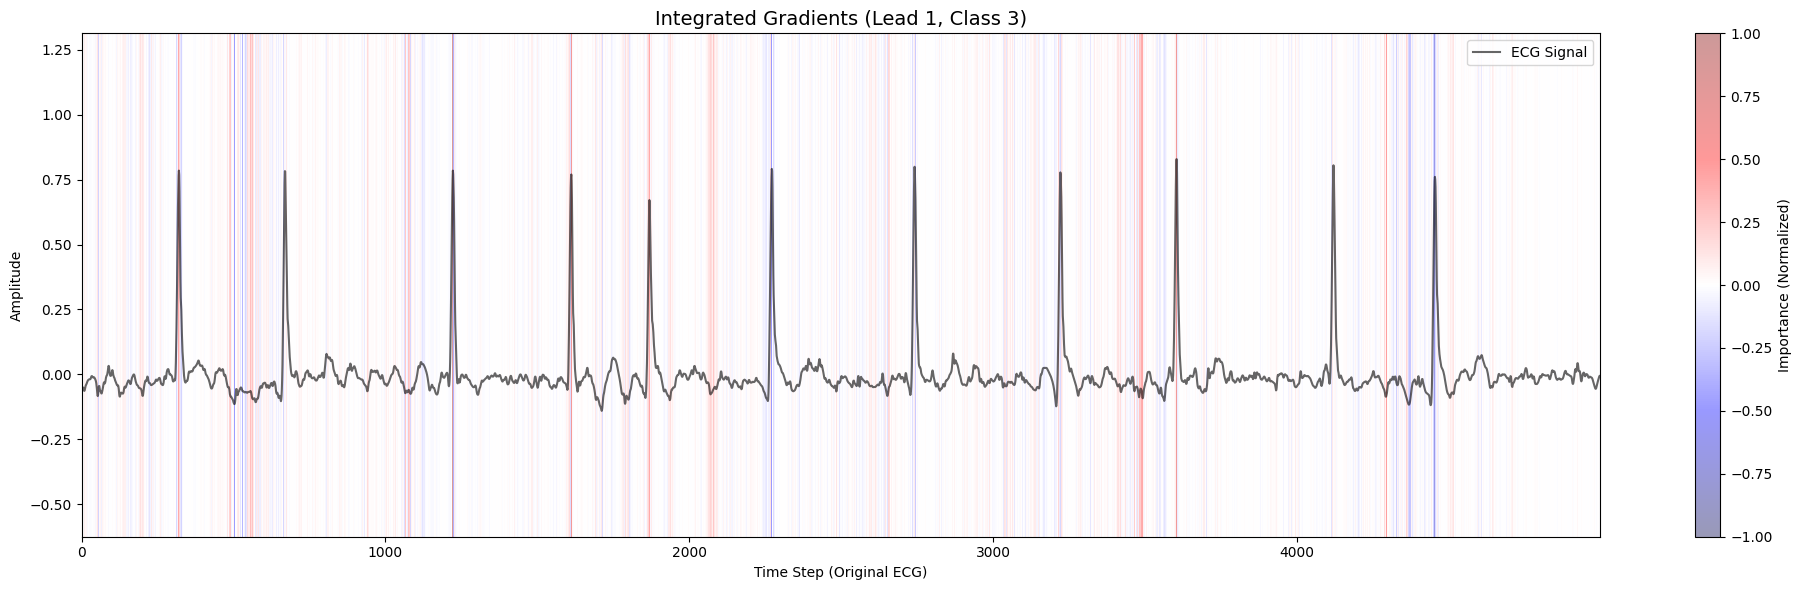

Attribution Range: -0.8337619304656982 to 1.0
Mean Abs Attribution: 0.03669976070523262
Actual label 3 - Atrial fibrillation. Predicted 3


In [ ]:
# 2. LIGHTX3ECG
lightx3ecg_model.eval()
lightx3ecg_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device) 
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

run_ig(lightx3ecg_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 17, 300, 12])
Computing Integrated Gradients attributions...


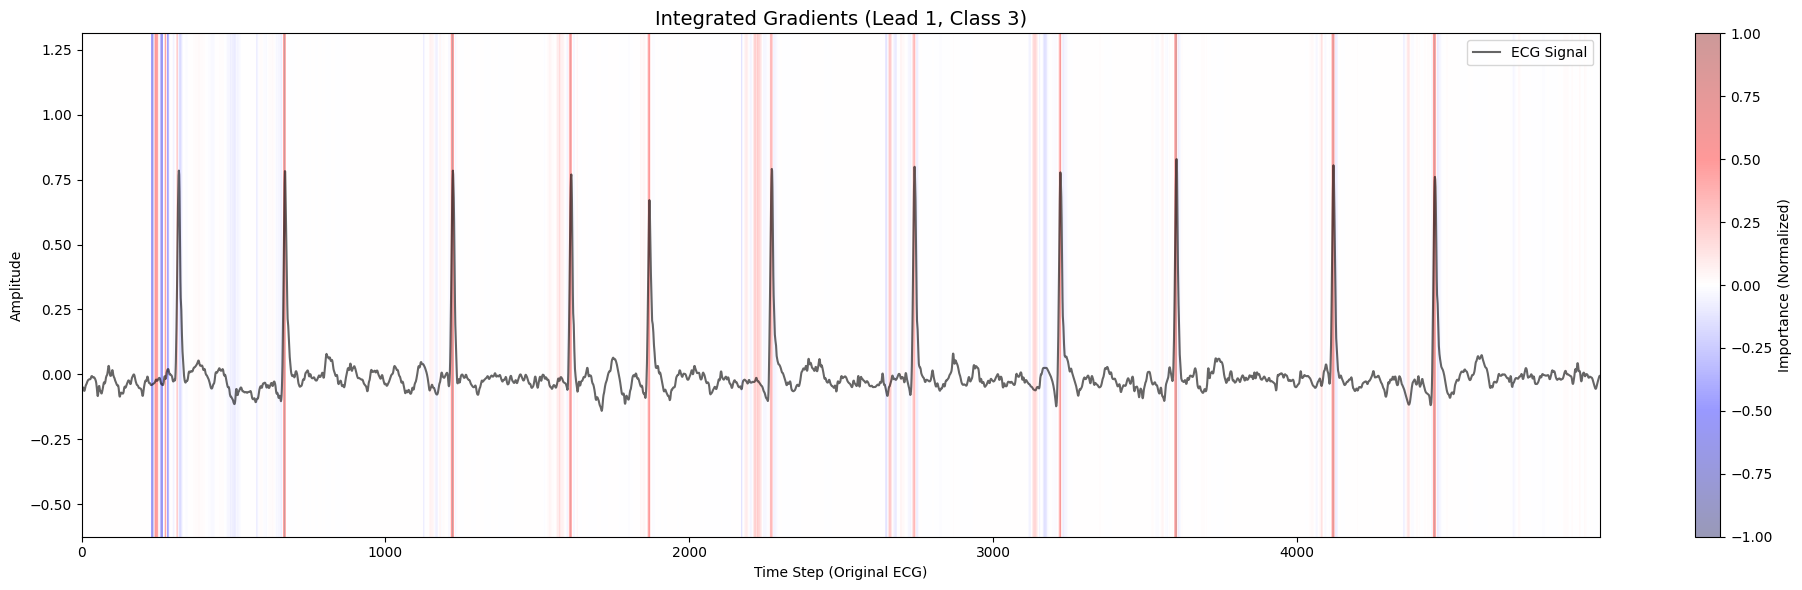

Attribution Range: -0.6586769342489893 to 1.0
Mean Abs Attribution: 0.024716617605756976
Actual label 3 - Atrial fibrillation. Predicted 3


In [154]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
run_ig(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


## SUM

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
import torch.nn.functional as F
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def run_ig_sum(model, x, y_true_description, y_true, baseline='zero', full=None, r_peaks=None, pre_samples=99, post_samples=201, window_size=50):
    set_seed(10)
    is_4d = len(x.shape) == 4
    if is_4d:
        model.train()
    else: 
        model.eval()
    device = x.device

    # -----------------------------
    # Model wrapper
    # -----------------------------
    def model_forward(input_tensor):
        return model(input_tensor)

    # Predict class
    with torch.no_grad():
        y_pred = torch.argmax(model_forward(x), dim=1).item()

    # -----------------------------
    # Baseline
    # -----------------------------
    if baseline == 'zero':
        baselines = torch.zeros_like(x)
    elif baseline == 'noise':
        baselines = torch.randn_like(x) * 0.01
    else:
        raise ValueError(f"Unknown baseline: {baseline}")

    # -----------------------------
    # Compute Integrated Gradients
    # -----------------------------
    ig = IntegratedGradients(model_forward)
    print("Computing Integrated Gradients attributions...")
    attributions, _ = ig.attribute(
        inputs=x,
        baselines=baselines,
        target=y_pred,
        return_convergence_delta=True
    )

    # -----------------------------
    # Plotting
    # -----------------------------
    lead_idx = 1  # Lead II

    if is_4d and full is not None and r_peaks is not None:
        # 4D beats → map back to full ECG
        full_len = full.shape[2]
        attr_full = np.zeros(full_len)
        ecg_full = full[0, lead_idx, :].cpu().detach().numpy()

        beat_len = x.shape[2]
        for i, peak in enumerate(r_peaks):
            start = max(0, peak - pre_samples)
            end = min(full_len, peak + post_samples)
            beat_attr = attributions[0, i, :, lead_idx].cpu().detach().numpy()

            # Interpolate to match the window
            beat_attr_interp = np.interp(np.arange(end - start),
                                        np.linspace(0, end - start, len(beat_attr)),
                                        beat_attr)
            attr_full[start:end] = beat_attr_interp

        # Aggregate over window_size samples
        attr_aggregated = aggregate_attributions(attr_full, window_size)
        
        # Expand aggregated attributions back to full resolution for plotting
        attr_expanded = np.repeat(attr_aggregated, window_size)
        # Trim to match original length
        attr_expanded = attr_expanded[:len(ecg_full)]
        
        attr_norm = attr_expanded / np.max(np.abs(attr_expanded)) if np.max(np.abs(attr_expanded)) > 0 else attr_expanded
        time_steps = np.arange(len(ecg_full))

    else:
        # Full ECG input (3D)
        if x.shape[1] == 12:  # channels-first
            ecg_full = x[0, lead_idx, :].cpu().detach().numpy()
            attr_full = attributions[0, lead_idx, :].cpu().detach().numpy()
        else:  # channels-last
            ecg_full = x[0, :, lead_idx].cpu().detach().numpy()
            attr_full = attributions[0, :, lead_idx].cpu().detach().numpy()
        
        # Aggregate over window_size samples
        attr_aggregated = aggregate_attributions(attr_full, window_size)
        
        # Expand aggregated attributions back to full resolution for plotting
        attr_expanded = np.repeat(attr_aggregated, window_size)
        # Trim to match original length
        attr_expanded = attr_expanded[:len(ecg_full)]
        
        attr_norm = attr_expanded / np.max(np.abs(attr_expanded)) if np.max(np.abs(attr_expanded)) > 0 else attr_expanded
        time_steps = np.arange(len(ecg_full))

    fig, ax = plt.subplots(figsize=(20, 6))
    ax.plot(time_steps, ecg_full, 'k-', alpha=0.6, label='ECG Signal')
    
    # Use pcolormesh like LIME
    im = ax.pcolormesh([time_steps, time_steps],
                       [np.min(ecg_full), np.max(ecg_full)],
                       [attr_norm, attr_norm],
                       cmap='seismic',
                       alpha=0.4,
                       vmin=-1, vmax=1)
    
    plt.colorbar(im, label="Importance (Normalized)")
    plt.xlabel("Time Step (Original ECG)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Debugging stats
    # -----------------------------
    print(f"Attribution Range: {attr_norm.min()} to {attr_norm.max()}")
    print(f"Mean Abs Attribution: {np.mean(np.abs(attr_norm))}")
    print(f"Number of windows: {len(attr_aggregated)}")
    print(f"Window size: {window_size} samples")
    print(f"Actual label {y_true} - {y_true_description}. Predicted {y_pred}")
    return attr_expanded


def aggregate_attributions(attr, window_size):
    n_windows = len(attr) // window_size
    # Truncate to fit complete windows
    attr_truncated = attr[:n_windows * window_size]
    # Reshape and sum over each window
    attr_reshaped = attr_truncated.reshape(n_windows, window_size)
    return np.sum(attr_reshaped, axis=1)


def aggregate_signal(signal, window_size):
    n_windows = len(signal) // window_size
    # Truncate to fit complete windows
    signal_truncated = signal[:n_windows * window_size]
    # Reshape and average over each window
    signal_reshaped = signal_truncated.reshape(n_windows, window_size)
    return np.mean(signal_reshaped, axis=1)

torch.Size([1, 12, 5000])
Computing Integrated Gradients attributions...


findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found bec

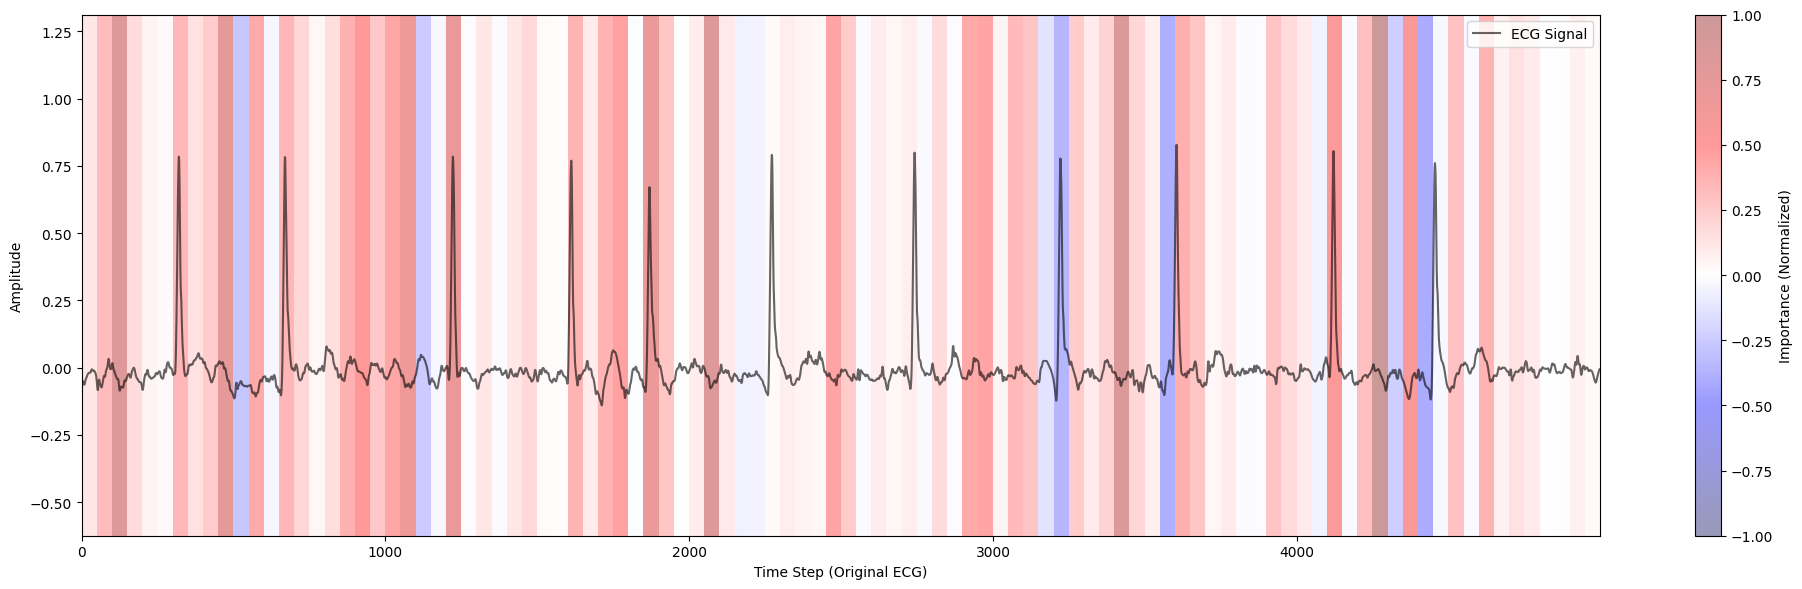

Attribution Range: -0.40104588866233826 to 1.0
Mean Abs Attribution: 0.22707881033420563
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [153]:
# 2. LIGHTX3ECG
lightx3ecg_model.eval()
lightx3ecg_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      
x = x.unsqueeze(0)  
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

lightx3ecg_ig_attr = run_ig_sum(lightx3ecg_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 12, 5000])
torch.Size([1, 5000, 12])
Computing Integrated Gradients attributions...


findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found bec

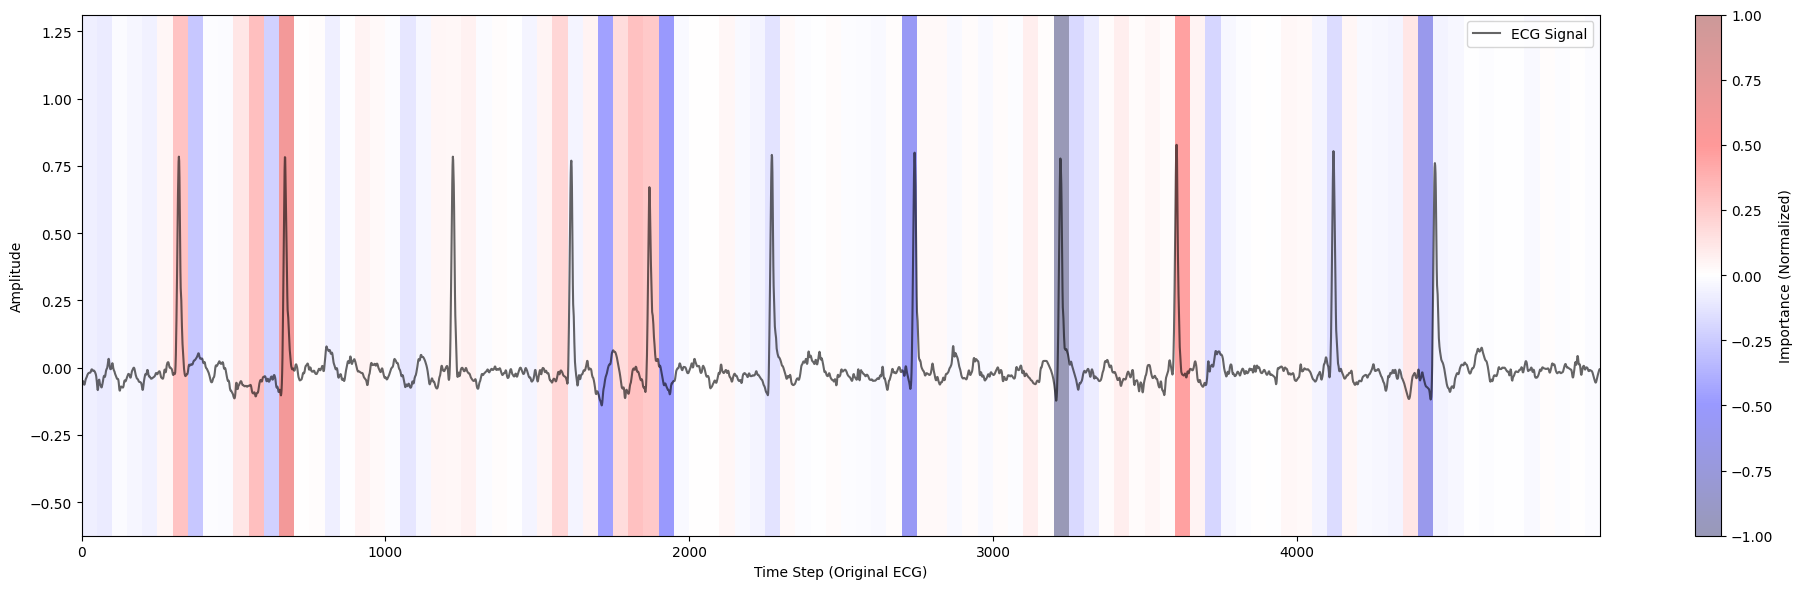

Attribution Range: -1.0 to 0.6051537394523621
Mean Abs Attribution: 0.09666110575199127
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [76]:
# 1. CATNET
catnet_model.eval()
catnet_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)  # (12, 7000)
x = x[:, :5000]      # (12, 5000) -> truncate time, keep all leads
x = x.unsqueeze(0)   # (1, 12, 5000) -> batch dimension
print(x.shape)       # (1, 12, 5000)
x = x.transpose(1, 2)    # (1, Channels, 5000)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

catnet_ig_attr = run_ig_sum(catnet_model, x, y_true_description, y_true, 'zero')

torch.Size([1, 17, 300, 12])
Computing Integrated Gradients attributions...


findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found because none of the following families were found: dejavuserif
findfont: Generic family 'serif' not found bec

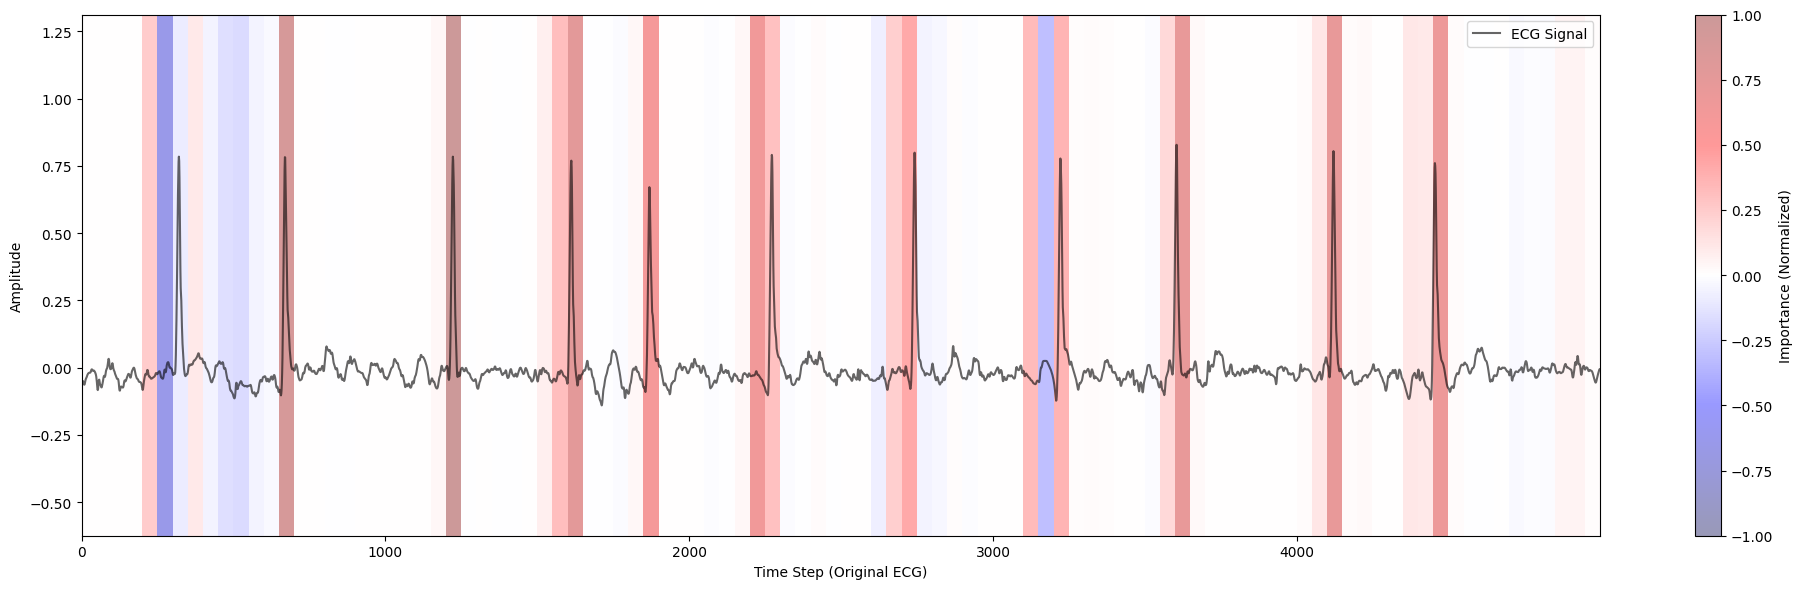

Attribution Range: -0.6466345695585004 to 1.0
Mean Abs Attribution: 0.11240342032958459
Number of windows: 100
Window size: 50 samples
Actual label 3 - Atrial fibrillation. Predicted 3


In [110]:
# 3. HAN
han_model.eval()
han_model.to(device)
idx = 24
x = torch.tensor(samples[idx]['beats'], dtype=torch.float32, device=device)  # (12, 7000)
x = x.unsqueeze(0)
print(x.shape)
y_true_description = samples[idx]['label_description'] 
y_true = samples[idx]['label_idx'] 

full_ecg = torch.tensor(samples[idx]['full_ecg_signal'], dtype=torch.float32, device=device)
full_ecg = full_ecg[:, :5000]  
full_ecg = full_ecg.unsqueeze(0)   

r_peaks = detect_r_peaks(full_ecg[0].cpu().numpy(), fs=500)  # get the fused R-peaks
han_ig_attr = run_ig_sum(han_model, x, y_true_description, y_true, baseline='zero', full=full_ecg, r_peaks=r_peaks, pre_samples=99, post_samples=201)


In [ ]:
import numpy as np
import scipy.stats as stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def calculate_agreement(attr_ig, attr_lime, threshold_percentile=20):
   
    # 1. Consistency Check
    min_len = min(len(attr_ig), len(attr_lime))
    attr_ig = attr_ig[:min_len]
    attr_lime = attr_lime[:min_len]

    # 2. Normalize both to [-1, 1] to compare magnitudes fairly
    # (LIME output is already normalized, but IG might not be)
    def normalize(a):
        m = np.max(np.abs(a))
        return a / m if m > 0 else a

    ig_norm = normalize(attr_ig)
    lime_norm = normalize(attr_lime)


    ig_thresh_val = np.percentile(np.abs(ig_norm), 100 - threshold_percentile)
    lime_thresh_val = np.percentile(np.abs(lime_norm), 100 - threshold_percentile)

    # Create Binary Masks (1 = Important, 0 = Unimportant/Zero)
    mask_ig = np.abs(ig_norm) > ig_thresh_val
    mask_lime = np.abs(lime_norm) > lime_thresh_val

    matches = (mask_ig == mask_lime)
    smc = np.sum(matches) / len(matches)

    results = {
        "Simple Matching Coeff (Overlap including 0s)": round(smc, 4),
        "Evaluated on top %": threshold_percentile
    }
    
    return results

metrics = calculate_agreement(catnet_ig_attr, catnet_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.76, 'Evaluated on top %': 20}


In [ ]:
metrics = calculate_agreement(han_ig_attr, han_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.8322, 'Evaluated on top %': 20}


In [156]:
metrics = calculate_agreement(lightx3ecg_ig_attr, lightx3cg_lime_attr, threshold_percentile=20)
print(metrics)

{'Simple Matching Coeff (Overlap including 0s)': 0.88, 'Evaluated on top %': 20}
